<a href="https://colab.research.google.com/github/emkafie/Machine-Learning/blob/main/Js15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1**

## **Langkah 1 - Import Library**

In [2]:
import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

## **Langkah 2 - Load Dataset**

In [15]:
# 1. Ekstraksi File ZIP
local_zip = 'images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

# 2. Fungsi Load Dataset
def load_dataset(img_dir):
    p = Path(img_dir)
    img_list = []
    # Iterasi folder (label)
    for folder in p.glob('*'):
        label = folder.name
        # Iterasi file gambar
        for file in folder.glob('*.jpg'):
            img = cv2.imread(str(file))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_list.append((img, label))
    return img_list

train_dir = "/content/dataset/images/training"
test_dir  = "/content/dataset/images/test"

train_img = load_dataset(train_dir)
test_img  = load_dataset(test_dir)

print(f"Jumlah data training: {len(train_img)}")
print(f"Jumlah data testing: {len(test_img)}")

Jumlah data training: 240
Jumlah data testing: 160


## **Langkah 3: Preprocessing (Resize & Label Encoding)**

In [16]:
def resize_image(img, size=(256,256)):
    return cv2.resize(img, size)

def label_encoder(label):
    return 1 if label == 'day' else 0

def preprocess(img_list):
    X = []
    y = []
    for img, label in img_list:
        img_std = resize_image(img)
        X.append(img_std)
        y.append(label_encoder(label))
    return X, y

X_train_img, y_train = preprocess(train_img)
X_test_img,  y_test  = preprocess(test_img)

## **Langkah 4: Ekstraksi Fitur HOG**

In [17]:
def extract_hog(X_imgs):
    feats = []
    for img in X_imgs:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_feat = hog(gray,
                       orientations=9,
                       pixels_per_cell=(8,8),
                       cells_per_block=(2,2),
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
        feats.append(hog_feat)
    return np.array(feats)

X_train_feat = extract_hog(X_train_img)
X_test_feat  = extract_hog(X_test_img)

## **Langkah 5: Normalisasi Fitur**

Data fitur dinormalisasi menggunakan StandardScaler agar memiliki distribusi dengan rata-rata 0 dan variansi 1. Hal ini membantu mempercepat proses pelatihan model.

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)

## **Langkah 6: Split Data Training & Validation**

Data training dipisahkan menjadi set pelatihan dan set validasi dengan rasio 80:20 untuk memantau kinerja model saat proses pelatihan berlangsung.

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_train,
    test_size=0.2,
    random_state=42
)

## **Langkah 7: Konversi Label ke Numpy Array**

List label dikonversi menjadi array NumPy agar kompatibel dengan input yang diharapkan oleh TensorFlow/Keras

In [20]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## **Langkah 8: Membangun Arsitektur Model**

Model Neural Network dibangun dengan arsitektur Sequential. Input layer menerima fitur HOG, diikuti oleh dua hidden layer dengan aktivasi ReLU, dan diakhiri dengan output layer satu neuron menggunakan aktivasi Sigmoid untuk klasifikasi biner.

In [21]:
input_dim = X_train.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     4,428,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,436,737 (16.92 MB)

 Trainable params: 4,436,737 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

## **Langkah 9: Training Model**

Model dilatih menggunakan data training dan validasi selama 20 epoch dengan ukuran batch 32.

In [22]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5803 - loss: 1.7904 - val_accuracy: 0.9167 - val_loss: 1.3502
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9848 - loss: 0.0458 - val_accuracy: 0.9375 - val_loss: 1.5857
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.7530e-04 - val_accuracy: 0.9375 - val_loss: 1.8452
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 2.3740e-05 - val_accuracy: 0.9375 - val_loss: 1.9876
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 2.9427e-05 - val_accuracy: 0.9375 - val_loss: 2.0657
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 8.0075e-05 - val_accuracy: 0.9375 - val_loss: 2.1075
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 1.0284e-05 - val_accuracy: 0.9375 - val_loss: 2.1309
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 2.0101e-05 - val_accuracy: 0

## **Langkah 10: Evaluasi Model**

Kinerja model diuji menggunakan data testing yang belum pernah dilihat sebelumnya untuk mengukur akurasi generalisasi.

In [23]:
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Akurasi Test: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8885 - loss: 3.4595
Akurasi Test: 0.9000


## **Langkah 11: Prediksi dan Laporan**

Model digunakan untuk memprediksi kelas pada data test. Laporan klasifikasi dan matriks kebingungan dihasilkan untuk analisis detail, serta grafik akurasi ditampilkan.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        80
           1       0.92      0.88      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160

Confusion Matrix:
 [[74  6]
 [10 70]]


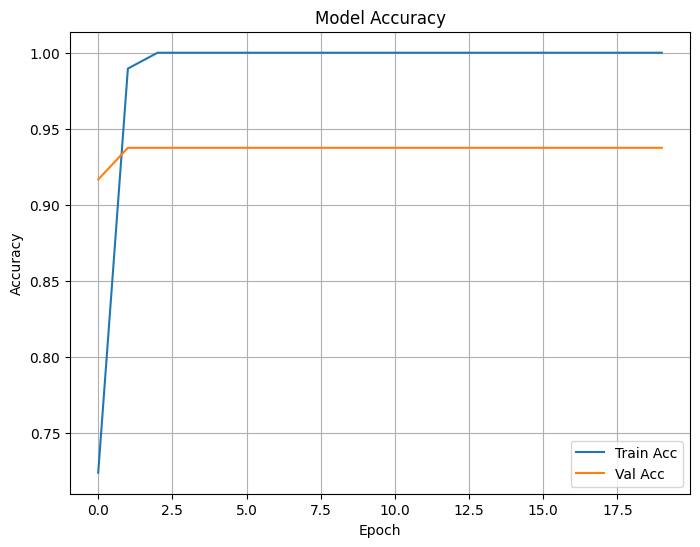

In [24]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## **Langkah 12: Menyimpan Model dan Scaler**

In [25]:
# Simpan Model
model.save('day_night_model.h5')
print("✅ Model berhasil disimpan sebagai: day_night_model.h5")

# Simpan Scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler berhasil disimpan sebagai: scaler.pkl")

✅ Model berhasil disimpan sebagai: day_night_model.h5
✅ Scaler berhasil disimpan sebagai: scaler.pkl
